In [ ]:
#!pip install transformers datasets torch scikit-learn matplotlib seaborn pandas numpy
#!pip install accelerate evaluate

In [ ]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding
)
from datasets import Dataset, DatasetDict
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print("Libraries imported successfully!")
print(f"Using device: {'GPU' if torch.cuda.is_available() else 'CPU'}")


Libraries imported successfully!
Using device: GPU


In [ ]:
# Cell 3: Define GoEmotions emotion labels
# The 27 emotion categories in GoEmotions dataset
EMOTION_LABELS = [
    'admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring',
    'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval',
    'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief',
    'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization',
    'relief', 'remorse', 'sadness', 'surprise', 'sympathy'
]

# Create label to id mapping
label2id = {label: i for i, label in enumerate(EMOTION_LABELS)}
id2label = {i: label for i, label in enumerate(EMOTION_LABELS)}

print(f"Number of emotion categories: {len(EMOTION_LABELS)}")
print("Emotion labels:", EMOTION_LABELS)


Number of emotion categories: 28
Emotion labels: ['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'sympathy']


In [ ]:
# Cell 4: Load and prepare the GoEmotions dataset
from datasets import load_dataset

# Load the GoEmotions dataset from Hugging Face
print("Loading GoEmotions dataset...")
dataset = load_dataset("go_emotions")

print("Dataset structure:")
print(dataset)
print("\nTrain set size:", len(dataset['train']))
print("Validation set size:", len(dataset['validation']))
print("Test set size:", len(dataset['test']))


Loading GoEmotions dataset...
Dataset structure:
DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 43410
    })
    validation: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 5426
    })
    test: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 5427
    })
})

Train set size: 43410
Validation set size: 5426
Test set size: 5427


In [ ]:
# Cell 5: Explore the dataset
# Look at some examples
print("Sample data points:")
for i in range(10):
    example = dataset['train'][i]
    print(f"\nExample {i+1}:")
    print(f"Text: {example['text']}")
    print(f"Labels: {example['labels']}")
    # Convert label indices to emotion names
    emotion_names = []
    # print(f"Label length: {len(EMOTION_LABELS)}")
    for label_id in example['labels']:
        # print(f"Label ID: {label_id}")
        if 0 <= label_id < len(EMOTION_LABELS):
            emotion_names.append(EMOTION_LABELS[label_id])
        else:
            print(f"Warning: Label index {label_id} out of range for EMOTION_LABELS. Skipping.")
    print(f"Emotions: {emotion_names}")

Sample data points:

Example 1:
Text: My favourite food is anything I didn't have to cook myself.
Labels: [27]
Emotions: ['sympathy']

Example 2:
Text: Now if he does off himself, everyone will think hes having a laugh screwing with people instead of actually dead
Labels: [27]
Emotions: ['sympathy']

Example 3:
Text: WHY THE FUCK IS BAYLESS ISOING
Labels: [2]
Emotions: ['anger']

Example 4:
Text: To make her feel threatened
Labels: [14]
Emotions: ['fear']

Example 5:
Text: Dirty Southern Wankers
Labels: [3]
Emotions: ['annoyance']

Example 6:
Text: OmG pEyToN iSn'T gOoD eNoUgH tO hElP uS iN tHe PlAyOfFs! Dumbass Broncos fans circa December 2015.
Labels: [26]
Emotions: ['surprise']

Example 7:
Text: Yes I heard abt the f bombs! That has to be why. Thanks for your reply:) until then hubby and I will anxiously wait 😝
Labels: [15]
Emotions: ['gratitude']

Example 8:
Text: We need more boards and to create a bit more space for [NAME]. Then we’ll be good.
Labels: [8, 20]
Emotions: ['desire',

=== TRAIN SET ANALYSIS ===
Total samples: 43410
Multi-label samples: 7102 (16.4%)


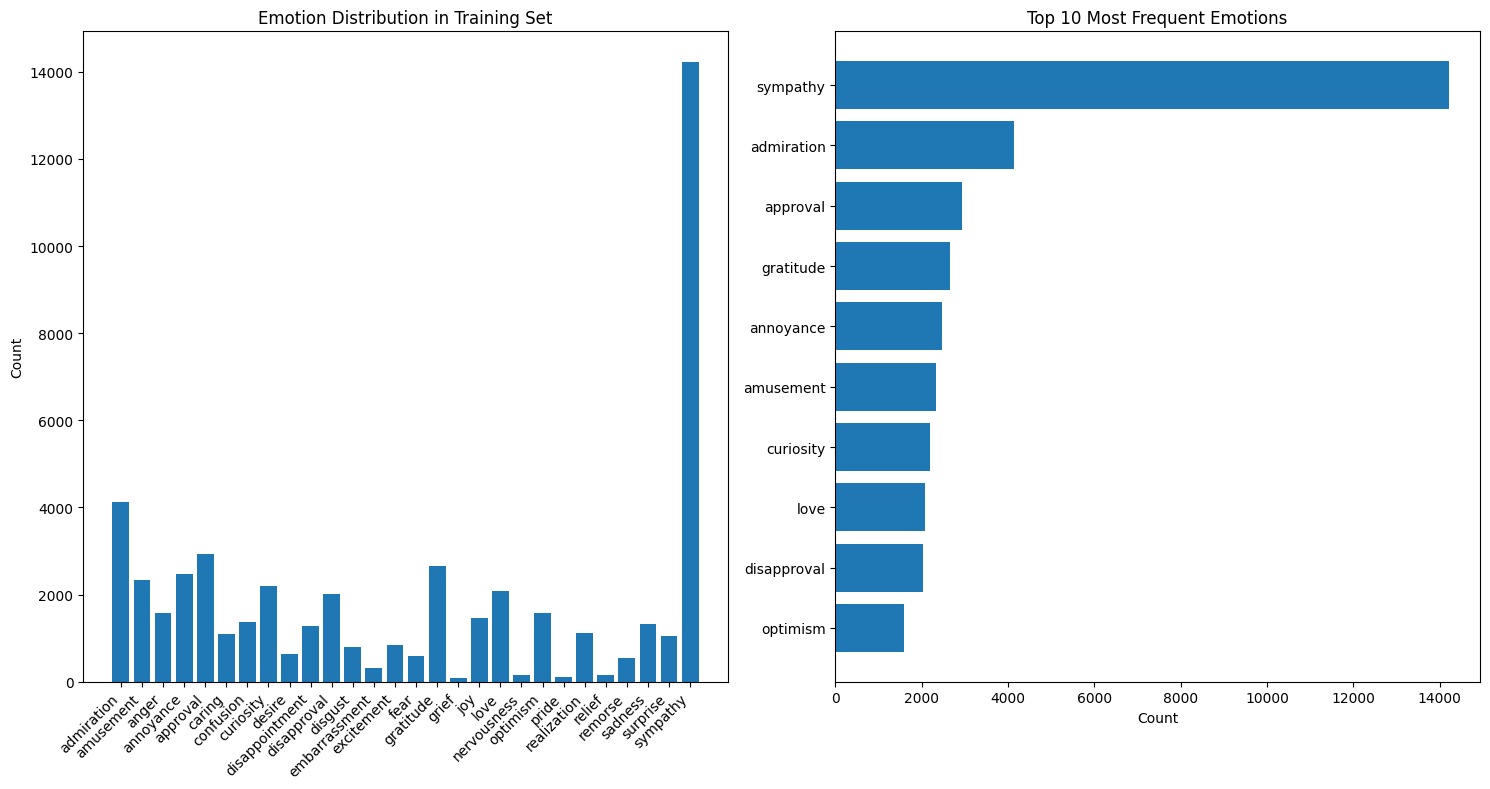

In [ ]:
# Cell 6: Data preprocessing and analysis
def analyze_dataset(dataset_split):
    """Analyze the distribution of emotions in the dataset"""
    texts = dataset_split['text']
    all_labels = dataset_split['labels']
    # print (all_labels)

    # Count occurrences of each emotion
    emotion_counts = {emotion: 0 for emotion in EMOTION_LABELS}
    total_samples = len(texts)
    multi_label_count = 0

    for labels in all_labels:
        # print (labels)
        if len(labels) > 1:
            multi_label_count += 1
        for label_id in labels:
            if 0 <= label_id < len(EMOTION_LABELS):
                emotion_counts[EMOTION_LABELS[label_id]] += 1
            else:
                print(f"Warning: Label index {label_id} out of range for EMOTION_LABELS. Skipping.")



    print(f"Total samples: {total_samples}")
    print(f"Multi-label samples: {multi_label_count} ({multi_label_count/total_samples*100:.1f}%)")

    return emotion_counts

# Analyze train set
print("=== TRAIN SET ANALYSIS ===")
train_emotion_counts = analyze_dataset(dataset['train'])

# Visualize emotion distribution
plt.figure(figsize=(15, 8))
emotions = list(train_emotion_counts.keys())
counts = list(train_emotion_counts.values())

plt.subplot(1, 2, 1)
bars = plt.bar(emotions, counts)
plt.xticks(rotation=45, ha='right')
plt.title('Emotion Distribution in Training Set')
plt.ylabel('Count')
plt.tight_layout()

plt.subplot(1, 2, 2)
# Top 10 most frequent emotions
top_emotions = sorted(train_emotion_counts.items(), key=lambda x: x[1], reverse=True)[:10]
top_names, top_counts = zip(*top_emotions)
plt.barh(top_names, top_counts)
plt.title('Top 10 Most Frequent Emotions')
plt.xlabel('Count')
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

In [ ]:
# Cell 7: Initialize tokenizer and model
MODEL_NAME = "microsoft/deberta-v3-base"

print(f"Loading tokenizer and model: {MODEL_NAME}")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# For multi-label classification, we need to set the problem type
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(EMOTION_LABELS),
    problem_type="multi_label_classification",
    id2label=id2label,
    label2id=label2id
)

print("Model and tokenizer loaded successfully!")
print(f"Model has {model.num_parameters():,} parameters")


Loading tokenizer and model: microsoft/deberta-v3-base


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model and tokenizer loaded successfully!
Model has 184,443,676 parameters


In [ ]:
# Cell 8: Tokenization function
def tokenize_function(examples):
    """Tokenize the input texts"""
    return tokenizer(
        examples['text'],
        truncation=True,
        padding=True,
        max_length=512
    )

def prepare_labels(examples):
    """Convert multi-label format to binary vectors"""
    batch_size = len(examples['labels'])
    labels = np.zeros((batch_size, len(EMOTION_LABELS)), dtype=np.float32)

    for i, label_list in enumerate(examples['labels']):
        for label_id in label_list:
            labels[i][label_id] = 1.0

    examples['labels'] = labels.tolist()
    return examples

# Apply tokenization and label preparation
print("Tokenizing dataset...")
tokenized_dataset = dataset.map(tokenize_function, batched=True)
tokenized_dataset = tokenized_dataset.map(prepare_labels, batched=True)

print("Tokenization completed!")

Tokenizing dataset...


Map:   0%|          | 0/43410 [00:00<?, ? examples/s]

Map:   0%|          | 0/5426 [00:00<?, ? examples/s]

Map:   0%|          | 0/5427 [00:00<?, ? examples/s]

Map:   0%|          | 0/43410 [00:00<?, ? examples/s]

Map:   0%|          | 0/5426 [00:00<?, ? examples/s]

Map:   0%|          | 0/5427 [00:00<?, ? examples/s]

Tokenization completed!


In [ ]:
# Cell 9: Create data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


In [ ]:
# Cell 10: Define evaluation metrics
def compute_metrics(eval_pred):
    """Compute metrics for multi-label classification"""
    predictions, labels = eval_pred

    # Apply sigmoid to get probabilities
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))

    # Convert to binary predictions (threshold = 0.5)
    y_pred = (probs > 0.5).int().numpy()
    y_true = labels.astype(int)

    # Calculate metrics
    # Micro-averaged F1 (overall performance)
    from sklearn.metrics import f1_score, precision_score, recall_score

    micro_f1 = f1_score(y_true, y_pred, average='micro')
    macro_f1 = f1_score(y_true, y_pred, average='macro')
    micro_precision = precision_score(y_true, y_pred, average='micro')
    micro_recall = recall_score(y_true, y_pred, average='micro')

    # Exact match accuracy (all labels must match)
    exact_match = np.mean(np.all(y_true == y_pred, axis=1))

    return {
        'micro_f1': micro_f1,
        'macro_f1': macro_f1,
        'micro_precision': micro_precision,
        'micro_recall': micro_recall,
        'exact_match_accuracy': exact_match
    }


In [ ]:
# Cell 11: Set up training arguments
training_args = TrainingArguments(
    output_dir='./results',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    eval_strategy="epoch", # Changed from evaluation_strategy
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="micro_f1",
    push_to_hub=False,
    logging_dir='./logs',
    logging_steps=100,
    warmup_steps=500,
    save_total_limit=2,
    seed=42
)

print("Training arguments configured!")

Training arguments configured!


In [ ]:
# # Cell 12: Initialize trainer
# trainer = Trainer(
#     model=model,
#     args=training_args,
#     train_dataset=tokenized_dataset['train'],
#     eval_dataset=tokenized_dataset['validation'],
#     tokenizer=tokenizer,
#     data_collator=data_collator,
#     compute_metrics=compute_metrics,
# )

# print("Trainer initialized!")

# Cell 12 (Modified): Initialize custom trainer

from transformers import Trainer
import torch.nn as nn

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = nn.BCEWithLogitsLoss()
        # Ensure labels are of the same type as logits (Float)
        loss = loss_fct(logits, labels.float())
        return (loss, outputs) if return_outputs else loss

# Initialize custom trainer
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['validation'],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

print("Custom Trainer initialized!")

Custom Trainer initialized!


In [ ]:
 #Cell 13: Train the model
print("Starting training...")
print("This may take a while depending on your hardware...")

# Train the model
trainer.train()

print("Training completed!")

Starting training...
This may take a while depending on your hardware...


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Currently logged in as: jjules (jjules-university-of-california-berkeley) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Micro F1,Macro F1,Micro Precision,Micro Recall,Exact Match Accuracy
1,0.094400,0.094396,0.523641,0.310549,0.699790,0.418339,0.393292
2,0.084700,0.084306,0.574335,0.404256,0.709804,0.482288,0.454478
3,0.077700,0.083731,0.586385,0.426776,0.692801,0.508307,0.468301


Training completed!


In [ ]:
# Cell 14: Evaluate on test set
print("Evaluating on test set...")
test_results = trainer.evaluate(tokenized_dataset['test'])

print("Test Results:")
for key, value in test_results.items():
    if 'eval_' in key:
        metric_name = key.replace('eval_', '')
        print(f"{metric_name}: {value:.4f}")


Evaluating on test set...


Test Results:
loss: 0.0833
micro_f1: 0.5890
macro_f1: 0.4305
micro_precision: 0.6914
micro_recall: 0.5130
exact_match_accuracy: 0.4688
runtime: 23.6412
samples_per_second: 229.5570
steps_per_second: 14.3820


In [ ]:
# Cell 15: Make predictions on test set
def predict_emotions(texts, threshold=0.5):
    """Predict emotions for given texts"""
    inputs = tokenizer(texts, truncation=True, padding=True,
                      max_length=512, return_tensors="pt")

    # Ensure inputs are on the same device as the model
    device = model.device
    inputs = {name: tensor.to(device) for name, tensor in inputs.items()}

    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        predictions = torch.sigmoid(outputs.logits)

    # Convert to binary predictions
    binary_preds = (predictions > threshold).int()

    results = []
    for i, pred in enumerate(binary_preds):
        predicted_emotions = [EMOTION_LABELS[j] for j, val in enumerate(pred) if val == 1]
        confidence_scores = {EMOTION_LABELS[j]: predictions[i][j].item()
                           for j in range(len(EMOTION_LABELS))}
        results.append({
            'text': texts[i],
            'predicted_emotions': predicted_emotions,
            'confidence_scores': confidence_scores
        })

    return results

# Test with some examples
test_texts = [
    "I'm so happy and excited about my new job!",
    "This is really frustrating and makes me angry.",
    "I'm worried about the exam tomorrow.",
    "Thank you so much for your help, I really appreciate it!",
    "I can't believe this happened, I'm so surprised!"
]

print("=== PREDICTION EXAMPLES ===")
predictions = predict_emotions(test_texts)

for pred in predictions:
    print(f"\nText: {pred['text']}")
    print(f"Predicted emotions: {pred['predicted_emotions']}")
    # Show top 3 confidence scores
    top_emotions = sorted(pred['confidence_scores'].items(),
                         key=lambda x: x[1], reverse=True)[:3]
    print("Top 3 confidence scores:")
    for emotion, score in top_emotions:
        print(f"  {emotion}: {score:.3f}")

=== PREDICTION EXAMPLES ===

Text: I'm so happy and excited about my new job!
Predicted emotions: ['excitement', 'joy']
Top 3 confidence scores:
  excitement: 0.688
  joy: 0.586
  admiration: 0.096

Text: This is really frustrating and makes me angry.
Predicted emotions: ['anger']
Top 3 confidence scores:
  anger: 0.813
  annoyance: 0.324
  disgust: 0.066

Text: I'm worried about the exam tomorrow.
Predicted emotions: ['fear']
Top 3 confidence scores:
  fear: 0.690
  nervousness: 0.306
  caring: 0.087

Text: Thank you so much for your help, I really appreciate it!
Predicted emotions: ['gratitude']
Top 3 confidence scores:
  gratitude: 0.992
  admiration: 0.499
  love: 0.015

Text: I can't believe this happened, I'm so surprised!
Predicted emotions: ['surprise']
Top 3 confidence scores:
  surprise: 0.882
  excitement: 0.072
  curiosity: 0.035


In [ ]:

# Cell 16: Detailed evaluation and visualization
# Get predictions for test set
test_predictions = trainer.predict(tokenized_dataset['test'])
sigmoid = torch.nn.Sigmoid()
test_probs = sigmoid(torch.Tensor(test_predictions.predictions))
test_binary_preds = (test_probs > 0.5).int().numpy()
test_labels = test_predictions.label_ids.astype(int)

# Per-class metrics
from sklearn.metrics import classification_report
print("=== PER-EMOTION CLASSIFICATION REPORT ===")
report = classification_report(
    test_labels,
    test_binary_preds,
    target_names=EMOTION_LABELS,
    zero_division=0
)
print(report)


=== PER-EMOTION CLASSIFICATION REPORT ===
                precision    recall  f1-score   support

    admiration       0.70      0.75      0.72       504
     amusement       0.81      0.88      0.84       264
         anger       0.55      0.47      0.51       198
     annoyance       0.52      0.14      0.22       320
      approval       0.58      0.32      0.41       351
        caring       0.53      0.38      0.44       135
     confusion       0.58      0.37      0.45       153
     curiosity       0.51      0.52      0.51       284
        desire       0.65      0.36      0.47        83
disappointment       0.48      0.08      0.14       151
   disapproval       0.47      0.31      0.38       267
       disgust       0.65      0.35      0.46       123
 embarrassment       1.00      0.03      0.05        37
    excitement       0.71      0.26      0.38       103
          fear       0.64      0.72      0.67        78
     gratitude       0.95      0.90      0.93       352
     

=== PER-EMOTION F1 SCORES ===
gratitude      : 0.927
amusement      : 0.842
love           : 0.813
admiration     : 0.724
remorse        : 0.694
fear           : 0.675
joy            : 0.637
sympathy       : 0.631
surprise       : 0.576
optimism       : 0.559
sadness        : 0.540
curiosity      : 0.515
anger          : 0.508
desire         : 0.465
disgust        : 0.455
confusion      : 0.448
caring         : 0.440
approval       : 0.413
excitement     : 0.383
disapproval    : 0.376
annoyance      : 0.218
disappointment : 0.136
embarrassment  : 0.053
realization    : 0.027
grief          : 0.000
nervousness    : 0.000
pride          : 0.000
relief         : 0.000


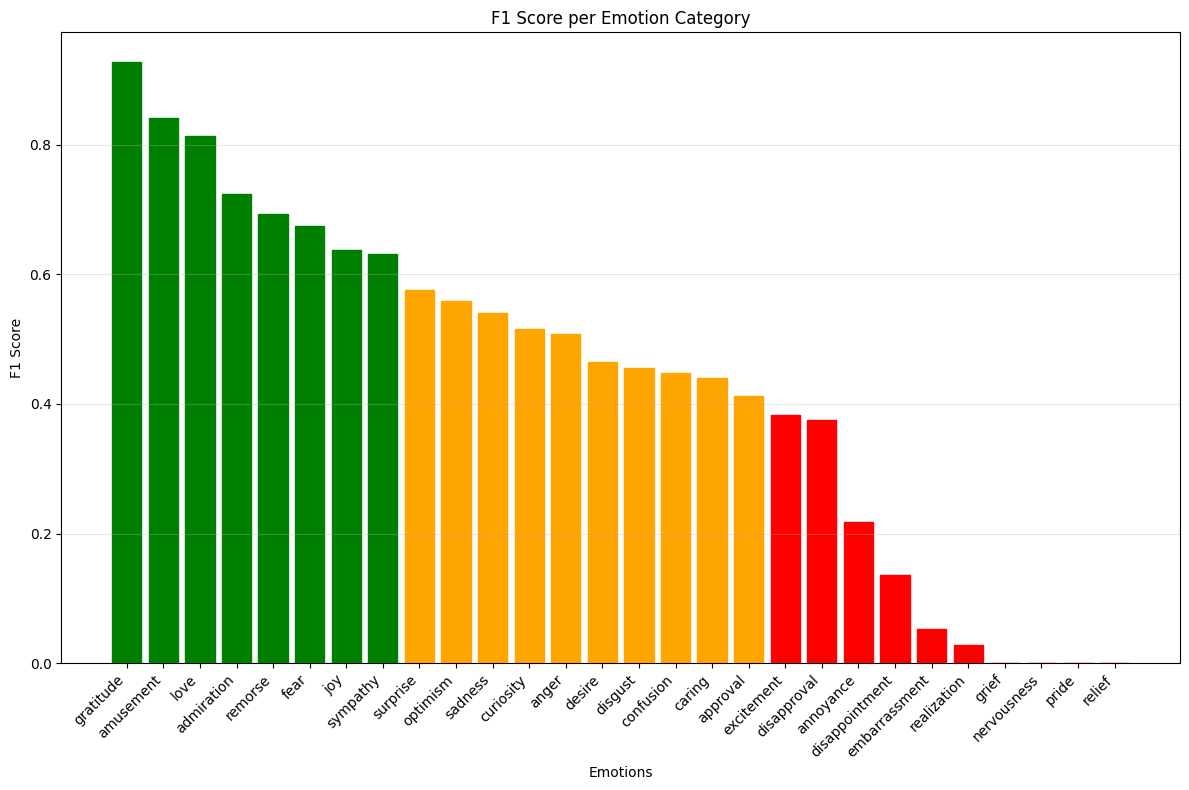

In [ ]:
# Cell 17: Confusion matrix visualization for top emotions
# Calculate per-emotion F1 scores
from sklearn.metrics import f1_score
per_emotion_f1 = []
for i in range(len(EMOTION_LABELS)):
    f1 = f1_score(test_labels[:, i], test_binary_preds[:, i], zero_division=0)
    per_emotion_f1.append((EMOTION_LABELS[i], f1))

# Sort by F1 score
per_emotion_f1.sort(key=lambda x: x[1], reverse=True)

print("=== PER-EMOTION F1 SCORES ===")
for emotion, f1 in per_emotion_f1:
    print(f"{emotion:15s}: {f1:.3f}")

# Visualize F1 scores
plt.figure(figsize=(12, 8))
emotions, f1_scores = zip(*per_emotion_f1)
bars = plt.bar(range(len(emotions)), f1_scores)
plt.xlabel('Emotions')
plt.ylabel('F1 Score')
plt.title('F1 Score per Emotion Category')
plt.xticks(range(len(emotions)), emotions, rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

# Color bars based on performance
for i, bar in enumerate(bars):
    if f1_scores[i] > 0.6:
        bar.set_color('green')
    elif f1_scores[i] > 0.4:
        bar.set_color('orange')
    else:
        bar.set_color('red')

plt.tight_layout()
plt.show()

In [ ]:
# Cell 18: Save the model
print("Saving the trained model...")
model.save_pretrained('./goemotions-deberta-v3')
tokenizer.save_pretrained('./goemotions-deberta-v3')
print("Model saved to './goemotions-deberta-v3'")


In [ ]:
# Cell 19: Load and test saved model
print("Testing saved model...")
from transformers import pipeline

# Create emotion classification pipeline
emotion_classifier = pipeline(
    "text-classification",
    model='./goemotions-deberta-v3',
    tokenizer='./goemotions-deberta-v3',
    return_all_scores=True
)

# Test the pipeline
test_text = "I'm absolutely thrilled about this amazing opportunity!"
results = emotion_classifier(test_text)

print(f"Text: {test_text}")
print("Emotion predictions:")
# Sort by score and show top 5
sorted_results = sorted(results[0], key=lambda x: x['score'], reverse=True)[:5]
for result in sorted_results:
    print(f"  {result['label']}: {result['score']:.3f}")

print("\n" + "="*50)
print("TRAINING COMPLETED SUCCESSFULLY!")
print("="*50)
print(f"Final test micro F1: {test_results['eval_micro_f1']:.4f}")
print(f"Final test macro F1: {test_results['eval_macro_f1']:.4f}")
print(f"Model saved to: './goemotions-deberta-v3'")
print("\nYou can now use this model for emotion classification!")

In [ ]:
# Cell 18: Mount Google Drive and save model
from google.colab import drive
import shutil
import os
import json
from datetime import datetime

# Mount Google Drive
print("Mounting Google Drive...")
drive.mount('/content/drive')

# Create directory structure in Google Drive
drive_model_path = '/content/drive/MyDrive/b-datasci-266/GoEmotions_Models'
drive_results_path = '/content/drive/MyDrive/b-datasci-266/GoEmotions_Results'

os.makedirs(drive_model_path, exist_ok=True)
os.makedirs(drive_results_path, exist_ok=True)

# Save model locally first
print("Saving the trained model locally...")
local_model_path = './goemotions-deberta-v3'
model.save_pretrained(local_model_path)
tokenizer.save_pretrained(local_model_path)

# Copy model to Google Drive
drive_model_full_path = f"{drive_model_path}/goemotions-deberta-v3"
print(f"Copying model to Google Drive: {drive_model_full_path}")

if os.path.exists(drive_model_full_path):
    shutil.rmtree(drive_model_full_path)
shutil.copytree(local_model_path, drive_model_full_path)

print("Model saved to Google Drive successfully!")





Mounting Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Saving the trained model locally...
Copying model to Google Drive: /content/drive/MyDrive/b-datasci-266/GoEmotions_Models/goemotions-deberta-v3
Model saved to Google Drive successfully!


In [ ]:
# Cell 19: Save training results to Google Drive
print("Saving training results to Google Drive...")

# Collect all training metrics and results
training_results = {
    'timestamp': datetime.now().isoformat(),
    'model_name': MODEL_NAME,
    'training_args': {
        'learning_rate': training_args.learning_rate,
        'num_train_epochs': training_args.num_train_epochs,
        'per_device_train_batch_size': training_args.per_device_train_batch_size,
        'per_device_eval_batch_size': training_args.per_device_eval_batch_size,
        'weight_decay': training_args.weight_decay,
        'warmup_steps': training_args.warmup_steps
    },
    'test_results': test_results,
    'per_emotion_f1_scores': dict(per_emotion_f1),
    'emotion_labels': EMOTION_LABELS,
    'dataset_info': {
        'train_size': len(dataset['train']),
        'validation_size': len(dataset['validation']),
        'test_size': len(dataset['test'])
    }
}

# Get training history if available
if hasattr(trainer.state, 'log_history'):
    training_results['training_history'] = trainer.state.log_history

# Save results to JSON file
results_filename = f"training_results_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json"
results_file_path = f"{drive_results_path}/{results_filename}"

with open(results_file_path, 'w') as f:
    json.dump(training_results, f, indent=2, default=str)

print(f"Training results saved to: {results_file_path}")

# Also save a summary CSV for easy viewing
summary_data = {
    'Metric': ['Micro F1', 'Macro F1', 'Micro Precision', 'Micro Recall', 'Exact Match Accuracy'],
    'Score': [
        test_results['eval_micro_f1'],
        test_results['eval_macro_f1'],
        test_results['eval_micro_precision'],
        test_results['eval_micro_recall'],
        test_results['eval_exact_match_accuracy']
    ]
}

summary_df = pd.DataFrame(summary_data)
summary_csv_path = f"{drive_results_path}/model_summary_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
summary_df.to_csv(summary_csv_path, index=False)

print(f"Summary results saved to: {summary_csv_path}")
print("All results saved to Google Drive successfully!")


Saving training results to Google Drive...
Training results saved to: /content/drive/MyDrive/b-datasci-266/GoEmotions_Results/training_results_20250729_194156.json
Summary results saved to: /content/drive/MyDrive/b-datasci-266/GoEmotions_Results/model_summary_20250729_194156.csv
All results saved to Google Drive successfully!


In [ ]:
# Cell 20: Function to load model from Google Drive
def load_model_from_drive():
    """Load the trained model from Google Drive"""
    print("Mounting Google Drive...")
    drive.mount('/content/drive')

    drive_model_path = '/content/drive/MyDrive/GoEmotions_Models/goemotions-deberta-v3'

    if not os.path.exists(drive_model_path):
        print(f"Model not found at {drive_model_path}")
        print("Available models in Google Drive:")
        models_dir = '/content/drive/MyDrive/GoEmotions_Models'
        if os.path.exists(models_dir):
            for item in os.listdir(models_dir):
                print(f"  - {item}")
        return None, None

    print(f"Loading model from Google Drive: {drive_model_path}")

    try:
        # Load tokenizer
        tokenizer = AutoTokenizer.from_pretrained(drive_model_path)

        # Load model
        model = AutoModelForSequenceClassification.from_pretrained(
            drive_model_path,
            num_labels=len(EMOTION_LABELS),
            problem_type="multi_label_classification",
            id2label=id2label,
            label2id=label2id
        )

        print("Model loaded successfully from Google Drive!")
        print(f"Model has {model.num_parameters():,} parameters")

        return model, tokenizer

    except Exception as e:
        print(f"Error loading model: {str(e)}")
        return None, None


In [ ]:

# Cell 21: Smart training - only train if model doesn't exist
def smart_train():
    """Train only if model doesn't exist in Google Drive, otherwise load existing model"""
    global model, tokenizer, trainer

    print("Checking for existing model in Google Drive...")
    drive.mount('/content/drive')

    drive_model_path = '/content/drive/MyDrive/GoEmotions_Models/goemotions-deberta-v3'

    if os.path.exists(drive_model_path):
        print("✅ Found existing trained model in Google Drive!")
        print("Loading existing model instead of training...")

        loaded_model, loaded_tokenizer = load_model_from_drive()

        if loaded_model is not None and loaded_tokenizer is not None:
            model = loaded_model
            tokenizer = loaded_tokenizer

            # Create trainer with loaded model for evaluation
            trainer = Trainer(
                model=model,
                args=training_args,
                train_dataset=tokenized_dataset['train'],
                eval_dataset=tokenized_dataset['validation'],
                tokenizer=tokenizer,
                data_collator=data_collator,
                compute_metrics=compute_metrics,
            )

            print("✅ Model loaded successfully! Ready for evaluation and inference.")
            print("💡 To force retraining, delete the model folder from Google Drive first.")
            return True
        else:
            print("❌ Failed to load existing model. Will proceed with training.")
            return False
    else:
        print("🔄 No existing model found. Starting training...")
        return False

# Execute smart training
model_loaded = smart_train()

if not model_loaded:
    print("Starting training...")
    print("This may take a while depending on your hardware...")

    # Train the model
    trainer.train()

    print("Training completed!")

    # Save to Google Drive (will execute cells 18-19)
    print("Saving model and results to Google Drive...")
else:
    print("Skipping training - using loaded model.")


In [ ]:
# Cell 22: Quick model testing function
def quick_test_model():
    """Quick function to test the model with sample texts"""
    test_texts = [
        "I'm so happy and excited about my new job!",
        "This is really frustrating and makes me angry.",
        "I'm worried about the exam tomorrow.",
        "Thank you so much for your help, I really appreciate it!",
        "I can't believe this happened, I'm so surprised!"
    ]

    print("=== QUICK MODEL TEST ===")
    predictions = predict_emotions(test_texts)

    for pred in predictions:
        print(f"\nText: {pred['text']}")
        print(f"Predicted emotions: {pred['predicted_emotions']}")
        # Show top 3 confidence scores
        top_emotions = sorted(pred['confidence_scores'].items(),
                             key=lambda x: x[1], reverse=True)[:3]
        print("Top 3 confidence scores:")
        for emotion, score in top_emotions:
            print(f"  {emotion}: {score:.3f}")

# Test the model (whether loaded or freshly trained)
quick_test_model()



In [ ]:
# Cell 23: Load and test saved model
print("Testing saved model...")
from transformers import pipeline

# Create emotion classification pipeline
emotion_classifier = pipeline(
    "text-classification",
    model='./goemotions-deberta-v3',
    tokenizer='./goemotions-deberta-v3',
    return_all_scores=True
)

# Test the pipeline
test_text = "I'm absolutely thrilled about this amazing opportunity!"
results = emotion_classifier(test_text)

print(f"Text: {test_text}")
print("Emotion predictions:")
# Sort by score and show top 5
sorted_results = sorted(results[0], key=lambda x: x['score'], reverse=True)[:5]
for result in sorted_results:
    print(f"  {result['label']}: {result['score']:.3f}")

print("\n" + "="*50)
print("TRAINING COMPLETED SUCCESSFULLY!")
print("="*50)
print(f"Final test micro F1: {test_results['eval_micro_f1']:.4f}")
print(f"Final test macro F1: {test_results['eval_macro_f1']:.4f}")
print(f"Model saved to: './goemotions-deberta-v3'")
print("\nYou can now use this model for emotion classification!")